In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi
import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())

def get_pig_model(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_"+str(k1)+"_"+str(k2), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_original(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_"+str(k1)+"_"+str(k2)+"_orig", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128_original():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128_orig", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_96_full():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,7]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_FULL_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_atlas():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,251]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_atlas_new():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,103]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6_new", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,3]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_binary_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_binary_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_atlas_new():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,103]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6_new", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model


/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-05-19 13:02:57.225713: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-19 13:02:57.225926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cubic-login1
2025-05-19 13:02:57.225986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cubic-login1
2025-05-19 13:02:57.226278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2025-05-19 13:02:57.226416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2025-05-19 13:02:57.226447: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.183.1


In [2]:
k1=6
k2=6
validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"

subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model(k1,k2)
# combined_model = get_pig_model_original(k1,k2)


combined_model_128 = get_pig_model_128()
# combined_model_128 = get_pig_model_128_original()

# combined_model_96 = get_pig_model_96()
combined_model_96 = get_pig_model_binary_96()
# combined_model_96 = get_pig_model_atlas()

atlas=True
combined_model_seg = get_pig_model_atlas_new()
# num_forground_classes=102 # 250
dial_param = 5 if atlas else 2

model is loading
models_gmm_6_6/weights_epoch_80.h5
model is loading
models_gmm_6_6_128/weights_epoch_40.h5
model is loading
models_gmm_6_6_96/weights_epoch_140.h5
model is loading
models_gmm_seg_atlas_6_6_new/weights_epoch_60.h5


In [ ]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage import zoom


import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

from scipy.ndimage import binary_dilation, binary_erosion
from sklearn.cluster import KMeans
import numpy as np

from scipy.ndimage import binary_erosion, binary_dilation, label
import numpy as np

from sklearn.decomposition import PCA

import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage import binary_dilation
import numpy as np
from scipy.ndimage import label



from scipy.ndimage import binary_erosion, binary_dilation, label
from scipy.ndimage import binary_erosion, binary_dilation
from sklearn.cluster import KMeans
import numpy as np







import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation
from sklearn.cluster import KMeans





import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
# from skimage.filters import threshold_otsu


# Define a 3D structuring element (e.g., 3x3x3 cube)
structure = np.ones((3, 3, 3), dtype=bool)


validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"
validation_folder_path = "results"

# validation_folder_path = "/gpfs/fs001/cbica/home/broodman/Pig_project"

subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
random.shuffle(subfolders)


combined_model = get_pig_model(k1,k2)
combined_model_128 = get_pig_model_128()

import numpy as np

import numpy as np
from scipy.ndimage import gaussian_filter, sobel

import numpy as np
from scipy.ndimage import gaussian_filter, sobel, label, binary_opening



# def majority_vote_mask(mask1, mask2, mask3):
#     """
#     Performs majority voting on three binary masks.
#     Voxels with values above 1 in the sum of the masks will be set to 1, others will be set to 0.
    
#     Parameters:
#     - mask1 (ndarray): First binary mask (same shape as the others).
#     - mask2 (ndarray): Second binary mask (same shape as the others).
#     - mask3 (ndarray): Third binary mask (same shape as the others).
    
#     Returns:
#     - final_mask (ndarray): A binary mask where the majority rule is applied.
#     """
#     # Sum the three masks element-wise
#     combined_sum = mask1 + mask2 + mask3
    
#     # Apply majority voting: voxels where sum > 1 are set to 1, else 0
#     final_mask = (combined_sum > 1).astype(np.int32)
    
#     return final_mask

def fill_holes_per_class(mask, labels=None):
    filled_mask = np.zeros_like(mask)
    if labels is None:
        labels = np.unique(mask)
        labels = labels[labels != 0]  # skip background

    for label in labels:
        class_mask = (mask == label)
        filled_class = ndi.binary_fill_holes(class_mask)
        filled_mask[filled_class] = label

    return filled_mask

from scipy.ndimage import binary_dilation, binary_erosion

def fill_holes_by_dilate_erode(mask, iterations=2):
    filled_mask = np.zeros_like(mask)
    labels = np.unique(mask)
    labels = labels[labels != 0]  # Skip background

    for label in labels:
        binary = (mask == label)
        # Dilate first to close small holes
        dilated = binary_dilation(binary, iterations=iterations)
        # Erode to restore the shape
        cleaned = binary_erosion(dilated, iterations=iterations)
        filled_mask[cleaned] = label

    return filled_mask



import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

# def kmeans_merge_fg_and_prune(img, fg_mask, n_bg_clusters=5):
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation
from scipy.ndimage import gaussian_filter
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

import numpy as np
from scipy.ndimage import gaussian_filter, binary_dilation
from sklearn.mixture import GaussianMixture



def trim_mask(pred_mask, mask_dtype=np.uint8, proximity=2, remove_top_n=1):
    """
    Keeps the dominant class and nearby-attached small classes (within `proximity` voxels),
    but excludes the top-N largest non-dominant labels.

    Parameters:
        pred_mask (np.ndarray): labeled input mask
        mask_dtype (np.dtype): output data type (e.g., np.uint8)
        proximity (int): voxel distance to include nearby labels
        remove_top_n (int): number of largest non-dominant labels to exclude

    Returns:
        np.ndarray: final mask with original labels preserved
    """
    flat = pred_mask.ravel()
    labels, counts = np.unique(flat[flat > 0], return_counts=True)
    if len(counts) == 0:
        return np.zeros_like(pred_mask, dtype=mask_dtype)

    dominant_label = labels[np.argmax(counts)]
    dominant_mask = (pred_mask == dominant_label)
    expanded = binary_dilation(dominant_mask, iterations=proximity)

    # Sizes of all other labels
    label_sizes = {label: np.sum(pred_mask == label) for label in labels if label != dominant_label}
    sorted_labels = sorted(label_sizes.items(), key=lambda x: x[1], reverse=True)
    excluded_labels = set([lbl for lbl, _ in sorted_labels[:remove_top_n]])

    # Initialize final mask with the dominant region
    final_mask = np.zeros_like(pred_mask, dtype=mask_dtype)
    final_mask[dominant_mask] = dominant_label

    # Include small nearby-attached labels
    for label in labels:
        if label == dominant_label or label in excluded_labels:
            continue
        label_mask = (pred_mask == label)
        if np.any(label_mask & expanded):
            final_mask[label_mask] = label

    print("Dominant label:", dominant_label)
    print("Excluded labels (top {}):".format(remove_top_n), excluded_labels)
    print("Labels in final mask:", np.unique(final_mask))

    return final_mask

import numpy as np
from sklearn.decomposition import PCA

import numpy as np
from scipy.ndimage import binary_dilation



import numpy as np
from scipy.ndimage import label

def extract_labeled_largest_component(labeled_mask):
    """
    Returns a labeled mask where only the region under the largest connected component
    (from the binarized version) is preserved. All other areas are set to 0.

    Parameters:
        labeled_mask (np.ndarray): input mask with integer class labels

    Returns:
        np.ndarray: same shape as input, only largest binary component retained
                    with original labels
    """
    binary_mask = (labeled_mask > 0)

    # Step 2: Label connected components
    connected, num = label(binary_mask)
    if num == 0:
        return np.zeros_like(labeled_mask)

    # Step 3: Find largest component
    sizes = np.bincount(connected.ravel())
    sizes[0] = 0  # background
    largest_label = np.argmax(sizes)
    largest_region = (connected == largest_label)

    # Step 4: Mask original labels using that region
    result = np.where(largest_region, labeled_mask, 0)

    return result

from scipy.ndimage import binary_erosion, distance_transform_edt
import numpy as np
from scipy.ndimage import binary_erosion, distance_transform_edt

def prune_mask_by_distance_from_core(mask1, mask2, distance_thresh=10, erosion_iter=2):
    """
    Removes distant voxels in mask1 that are farther than `distance_thresh`
    from the eroded core of mask2.

    Parameters:
        mask1 (np.ndarray): binary mask to prune
        mask2 (np.ndarray): reference mask whose core is trusted
        distance_thresh (int): distance threshold in voxels
        erosion_iter (int): erosion depth to define core from mask2

    Returns:
        pruned_mask (np.ndarray): mask1 cleaned based on distance to core of mask2
    """
    # Step 1: Erode mask2 to get core
    core = binary_erosion(mask2, iterations=erosion_iter)

    # Step 2: Compute distance from core
    distance_from_core = distance_transform_edt(~core)

    # Step 3: Remove mask1 voxels that are too far from core
    pruned_mask = (mask1 > 0) & (distance_from_core <= distance_thresh)
    
    return pruned_mask.astype(np.uint8)

import numpy as np
from scipy.ndimage import center_of_mass, distance_transform_edt

import numpy as np
from scipy.ndimage import binary_dilation

import numpy as np
from scipy.ndimage import binary_dilation, label, sum as ndi_sum

from scipy.ndimage import binary_dilation, label, distance_transform_edt, sum as ndi_sum


def combine_mask_with_dilated_label(pred_192_2, initial_prediction, target_label=93, dilation_iters=50):
    """
    Combines pred_192_2 and initial_prediction into a binary mask.
    Uses binarized pred_192_2 in the largest dilated region around label==target_label,
    and initial_prediction elsewhere.

    Parameters:
        pred_192_2: np.ndarray, multi-class segmentation
        initial_prediction: np.ndarray, binary mask
        target_label: int, label to use as trust anchor (default: 93)
        dilation_iters: int, how many voxels to dilate label region

    Returns:
        final_binary_mask: np.ndarray, 0 for background, 2 for foreground
    """

    # Step 1: Find label==target_label region
    label_region = (pred_192_2 == target_label)
    if not np.any(label_region):
        print(f"Warning: Label {target_label} not found. Using initial_prediction everywhere.")
        return (initial_prediction > 0).astype(np.int32) * 2

    # Step 2: Dilate label region
    dilated_region = binary_dilation(label_region, iterations=dilation_iters)

    # Step 3: Extract largest connected component from dilated region
    labeled_components, num_components = label(dilated_region)
    if num_components == 0:
        print(f"Warning: No connected components after dilation. Using initial_prediction everywhere.")
        return (initial_prediction > 0).astype(np.int32) * 2

    component_sizes = ndi_sum(dilated_region, labeled_components, index=np.arange(1, num_components + 1))
    largest_component_label = np.argmax(component_sizes) + 1  # labels start from 1
    trusted_region = (labeled_components == largest_component_label)

    # Step 4: Binarize pred_192_2 → 0 or 2
    mask_binary = (pred_192_2 > 0).astype(np.int32) * 2

    # Step 5: Binarize initial_prediction → 0 or 2
    init_binary = (initial_prediction > 0).astype(np.int32) * 2

    # Step 6: Merge based on trusted region
    final_mask = np.where(trusted_region, mask_binary, init_binary)

    return final_mask

from scipy.ndimage import binary_erosion, label, sum as ndi_sum

from scipy.ndimage import binary_erosion, gaussian_filter, label
from scipy.ndimage import sum as ndi_sum

from scipy.ndimage import binary_erosion, gaussian_filter, label
from scipy.ndimage import sum as ndi_sum
import numpy as np

def clean_mask(image, mask, border=5, thresh=0.1, sigma=2.8):
    m = (mask > 0)
    struct = np.ones((3, 3, 3), dtype=bool)  # for 3D erosion
    eroded = binary_erosion(m, structure=struct, iterations=border)
    m[~eroded & (image < thresh)] = 0
    lbl, n = label(m)
    if n == 0: return np.zeros_like(mask)
    m = (lbl == 1 + np.argmax(ndi_sum(m, lbl, index=np.arange(1, n + 1))))
    return (gaussian_filter(m.astype(float), sigma) > 0.5).astype(mask.dtype)




def refine_prediction2(crop_img,image, mask, mask2, model, model_128,model_96, folder, new_image_size=(192, 192, 192), margin=0, cube_size=128):
    """
    Refines the segmentation prediction in two steps:
    1. Makes an initial prediction.
    2. Crops the image based on the prediction and runs the model again.
    
    Parameters:
    - crop_img (ndarray): The input image for prediction.
    - mask (ndarray): The binary mask.
    - model: The trained segmentation model.
    - new_image_size (tuple): The new voxel size for resizing (default is (192, 192, 192)).
    - margin (int): The margin to add around the bounding box (default is 10).
    - cube_size (int): The size of the bounding cube (default is 32).
    
    Returns:
    - final_prediction_resized (ndarray): The final refined prediction, resized to match the original input size.
    """

    orig_shape = image.shape
    voxsize = image.geom.voxsize
    folder_path = os.path.join("results", folder)
    os.makedirs(folder_path, exist_ok=True)
    affine = np.array(image.geom.vox2world)
    nib.save(nib.Nifti1Image(image.data, affine), os.path.join(folder_path, 'image.nii.gz'))
    
    # Step 1: Initial Prediction
    # Binarize the mask
    mask.data[mask.data != 0] = 1
    # nib.save(nib.Nifti1Image(mask.astype(np.int32), image.geom.vox2world), os.path.join(folder_path, 'mask.nii.gz'))

    # Compute mask center (using the provided find_bounding_box function)
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    print(crop_img.shape)
    
    # Make an initial prediction
    prediction_one_hot = model.predict(crop_img[None, ...], verbose=0)
    initial_prediction = np.argmax(prediction_one_hot, axis=-1)[0]
    ne.plot.volume3D(crop_img, slice_nos=ms)
    print("orig shape",orig_shape)
    print("Initial Prediction Result:")

    labeled, num_components = ndimage.label(initial_prediction > 0)
    largest_mask = labeled == np.argmax(ndimage.sum(initial_prediction > 0, labeled, range(num_components + 1)))
    initial_prediction = ndi.binary_fill_holes(largest_mask)
    initial_prediction = (initial_prediction > 0).astype(np.int32)
    nib.save(nib.Nifti1Image(sf.Volume(initial_prediction.astype(np.int32)).resize(voxsize,method="nearest")
                             .reshape(orig_shape).data, affine), os.path.join(folder_path, 'initial_prediction.nii.gz'))

    ne.plot.volume3D(initial_prediction, slice_nos=ms)
    print("first step: ",my_hard_dice(mask.data, initial_prediction))

    initial_prediction_dial = binary_dilation(initial_prediction, structure=structure, iterations=dial_param)
    crop_img = crop_img*(initial_prediction_dial>0)

    # Step 2: Use find_bounding_box function to get the bounding box
    x1, y1, z1, x2, y2, z2 = find_bounding_box(initial_prediction, cube_size=cube_size)
    cube = extract_cube(crop_img, x1, y1, z1, x2, y2, z2, cube_size=128)


    pred_192_1 = np.zeros((192,192,192))
    pred_192_2 = np.zeros((192,192,192))
    
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    # ne.plot.volume3D(cube, slice_nos=ms)

    # Step 3: Re-run the Model with the cropped image
    prediction_cropped_one_hot = model_128.predict(cube[None, ...], verbose=0)
    final_prediction = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
    pred_192_1[x1:x2, y1:y2, z1:z2] = final_prediction
    pred_192_1 = fill_holes_by_dilate_erode(pred_192_1, iterations=4)
    pred_192_1 = clean_mask(crop_img, pred_192_1,border=2, thresh=0.1, sigma=1.8)
    
    prediction_128= pred_192_1
    # pred_192_1[pred_192_1==1]=1
    nib.save(nib.Nifti1Image(sf.Volume(pred_192_1.astype(np.int32)).resize(voxsize,method="nearest")
                         .reshape(orig_shape).data, affine), os.path.join(folder_path, '128_prediction.nii.gz'))
    
    # labeled, num_components = ndimage.label(pred_192_1 > 0)
    # largest_mask = labeled == np.argmax(ndimage.sum(pred_192_1 > 0, labeled, range(num_components + 1)))
    # largest_mask = ndi.binary_fill_holes(largest_mask)
    # pred_192_1 = largest_mask
    # pred_192_1 = (pred_192_1 > 0).astype(np.int32)
    ne.plot.volume3D(pred_192_1, slice_nos=ms)
    print("second step: ",my_hard_dice(mask.data, pred_192_1))
    pred_192_1_before_dialation = pred_192_1
    print("##",voxsize)
    pred_192_1 = binary_dilation(pred_192_1, structure=structure, iterations=dial_param)
    crop_img = crop_img*(pred_192_1>0)

    nib.save(nib.Nifti1Image(sf.Volume(crop_img.astype(np.float32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'dilated.nii.gz'))
    ne.plot.volume3D(crop_img, slice_nos=ms)

    
    x1, y1, z1, x2, y2, z2 = find_bounding_box(pred_192_1, cube_size=128)
    cube = extract_cube(crop_img, x1, y1, z1, x2, y2, z2, cube_size=128)

    # else:
    zoom_in_factor = 0.6
    cube_zoomed = zoom(cube, zoom=zoom_in_factor, order=1)  # linear interpolation
    cube_zoomed = sf.Volume(cube_zoomed).reshape((96,96,96))

    prediction_cropped_one_hot = model_96.predict(cube_zoomed[None, ..., None], verbose=0)
    pred_96 = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
    zoom_out_factor = 1/0.6
    pred_96_zoomed_out = zoom(pred_96, zoom=zoom_out_factor, order=0)  # nearest neighbor for labels
    pred_192_2[x1:x2, y1:y2, z1:z2] = sf.Volume(pred_96_zoomed_out).reshape((128,128,128)).data
    pred_192_2 = np.where(pred_192_2 == 2, 2, initial_prediction)
    # pred_192_2 = extract_brain_mask(crop_img.data,pred_192_2>0, skull_threshold=200, erosion_margin=4)
    # pred_192_2 = smooth_mask_by_erode_dilate(pred_192_2)
    pred_192_2 = fill_holes_by_dilate_erode(pred_192_2, iterations=5)
    # pred_192_3 = extract_brain_mask(crop_img.data,pred_192_2, skull_threshold=100, erosion_margin=5)
    # pred_192_2 = extract_brain_mask(crop_img.data,pred_192_2)
    # pred_192_2 = kmeans_label_with_foreground(crop_img.data,pred_192_2)
    # pred_192_2 = kmeans_merge_fg_and_prune(crop_img.data, pred_192_2, n_bg_clusters=5,sigma=1)
    # pred_192_2 = gmm_merge_fg_and_prune(crop_img.data, pred_192_2, n_bg_components=5,sigma=0.9)
    
    
    # pred_192_2= add_missing_components(initial_prediction,pred_192_3)
    # pred_192_2 = fill_holes_by_dilate_erode(pred_192_2, iterations=2)

    # ne.plot.volume3D(pred_192_2, slice_nos=ms,cmaps=['tab20c'])
    # nib.save(nib.Nifti1Image(sf.Volume(pred_192_2.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'kmeans.nii.gz'))

    # pred_192_2 = relabel_brain_classes(pred_192_2,crop_img.data)
    print("Unique labels in pred_192_2 before trim:", np.unique(pred_192_2))
    pred_192_2 = trim_mask(pred_192_2, proximity=2,remove_top_n=4)
    pred_192_2 = extract_labeled_largest_component(pred_192_2)
    print("Unique labels in pred_192_2 after trim:", np.unique(pred_192_2))
    # pred_192_2 = majority_vote_mask(initial_prediction,pred_192_2,prediction_128)



    pred_192_2 = prune_mask_by_distance_from_core(pred_192_2,initial_prediction)

    nib.save(nib.Nifti1Image(sf.Volume(pred_192_2.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'second_prediction.nii.gz'))

    if atlas:
        crop_img = crop_img*(pred_192_2>0)
        zoom_in_factor = 2
        cube_zoomed = zoom(crop_img, zoom=zoom_in_factor, order=1)  # linear interpolation
        cube_zoomed = sf.Volume(cube_zoomed).reshape((192,192,192))
        # ne.plot.volume3D(cube_zoomed)
        # ne.plot.volume3D(cube_zoomed, slice_nos=ms)
        prediction_cropped_one_hot = combined_model_seg.predict(cube_zoomed[None, ..., None], verbose=0)
        pred_192 = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
        zoom_out_factor = 0.5
        pred_96_zoomed_out = zoom(pred_192, zoom=zoom_out_factor, order=0)
        print("################## segmentation")
        ne.plot.volume3D(pred_96_zoomed_out,cmaps=['tab20c'])
        pred_192_2 = sf.Volume(pred_96_zoomed_out).reshape((192,192,192)).data
        from scipy.ndimage import binary_erosion, distance_transform_edt


        # pred_192_3 = combine_mask_with_dilated_label2(pred_192_2.astype(np.int32),initial_prediction , prediction_128, 
        #                                              target_label=93,near_label=62,
        #                                              dilation_iters=5)
        pred_192_3 = combine_mask_with_dilated_label(pred_192_2.astype(np.int32),initial_prediction, target_label=93, dilation_iters=5)
        pred_192_3 = clean_mask(crop_img, pred_192_3)
        
        binarized = (pred_192_3 > 0).astype(np.int32) * 2
        binarized = fill_holes_by_dilate_erode(binarized, iterations=5)
        resized = sf.Volume(binarized).resize(voxsize, method="nearest").reshape(orig_shape).data
        nib.save(nib.Nifti1Image(resized, affine), os.path.join(folder_path, 'third_prediction.nii.gz'))
        

        pred_192_2[pred_192_3==0]=0 
        pred_192_2 = fill_holes_per_class(pred_192_2)
        nib.save(nib.Nifti1Image(sf.Volume(pred_192_2.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'seg_prediction.nii.gz'))

        
        binarized = (pred_192_2 > 0).astype(np.int32) * 2
        binarized = fill_holes_by_dilate_erode(binarized, iterations=5)
        resized = sf.Volume(binarized).resize(voxsize, method="nearest").reshape(orig_shape).data
        nib.save(nib.Nifti1Image(resized, affine), os.path.join(folder_path, 'seg_mask.nii.gz'))
        
        # pred_bin = binarized > 0

        # Initialize output map
        tp_fp_map = np.zeros_like(binarized, dtype=np.uint8)
        pred_bin = (pred_192_3 > 0).astype(np.int32)
        # Apply rules
        
        tp_fp_map[(mask2 == 1)] = 3
        tp_fp_map[(mask == 1)] = 2
        # tp_fp_map[(pred_bin == 1) & (mask == 0) & (mask2 == 1)] = 2
        # tp_fp_map[(pred_bin == 1) & (mask == 1) & (mask2 == 0)] = 3
       
        
        tp_fp_map[(pred_bin == 1) & (mask == 0) & (mask2 == 0)] = 4
        tp_fp_map[(pred_bin == 1) & (mask == 1) & (mask2 == 1)] = 1
        resized = sf.Volume(tp_fp_map).resize(voxsize, method="nearest").reshape(orig_shape).data
        nib.save(nib.Nifti1Image(resized, affine), os.path.join(folder_path, 'tp_fp_map.nii.gz'))
        
        crop_img = crop_img*(pred_bin>0)
        nib.save(nib.Nifti1Image(sf.Volume(crop_img.astype(np.float32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'cropped_image.nii.gz'))

        return pred_192_3>0
        

    


    # nib.save(nib.Nifti1Image(sf.Volume(pred_192.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'third_prediction.nii.gz'))
    return pred_192_2

# Store Dice coefficients
dice_scores = []

new_voxsize = [1, 1, 1]

import numpy as np
for folder in subfolders:
    folder_path = os.path.join(validation_folder_path, folder)
    folder_name = os.path.basename(folder_path)
    folder_path_2 = os.path.join("results", folder)
    
    # filename = os.path.join(folder_path, f"{folder_name}_T1.nii.gz")
    # mask_filename = os.path.join(folder_path, f"{folder_name}_T1_mask.nii.gz")

    filename = os.path.join(folder_path, f"image.nii.gz")
    mask_filename = os.path.join(folder_path, f"mask.nii.gz")


    if "JAW-076_1month" not in filename:
        continue

    # if "JAW-106_6month" in filename:
    #     print("NO MASK FOUND")
    #     continue
        
    print(filename)
    


    # Skip if no input file
    if not os.path.isfile(filename):
        continue
        
    # Load and process image
    filename = os.path.join(folder_path_2, 'image.nii.gz')
    image = sf.load_volume(filename)
    crop_img = image.resize(new_voxsize, method="linear").reshape([192, 192, 192, 1])
    orig_shape = image.shape
    orig_voxsize=crop_img.geom.voxsize

    # Binarize the mask
    

        # Load mask
    if not os.path.isfile(mask_filename):
        mask = sf.Volume(np.ones((192, 192, 192)))
    else:
        
        mask2 = sf.load_volume(mask_filename).reshape(orig_shape)#resize(new_voxsize, method="linear")
        affine = np.array(image.geom.vox2world)
        print("mask shape",mask2.shape,"image shape",image.shape)
        nib.save(nib.Nifti1Image(mask2.astype(np.int32), affine), os.path.join(folder_path_2, 'mask.nii.gz'))
        mask2 = mask2.resize(new_voxsize).reshape([192, 192, 192, 1])

        mask_filename = os.path.join(folder_path_2, f"mask_drew.nii.gz")
        mask = sf.load_volume(mask_filename).reshape(orig_shape)
        mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])
        
    mask.data[mask.data != 0] = 1
    mask2.data[mask2.data != 0] = 1

    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    
    prediction = refine_prediction2(crop_img, image, mask, mask2, combined_model,combined_model_128,combined_model_96, folder, new_image_size=(192, 192, 192))

    # Compute Dice coefficient
    mask_flat = mask.data.flatten()
    prediction_flat = prediction.flatten()>0
    dice_score = 2 * np.sum(mask_flat * prediction_flat) / (np.sum(mask_flat) + np.sum(prediction_flat))
    if np.sum(mask.data)<1000:
        continue
    dice_scores.append(dice_score)

    print(f"Dice coefficient for {folder_name}: {dice_score:.4f}")
    # break

# Overall Dice coefficient and visualization
overall_dice = np.mean(dice_scores)
print(f"Overall Dice coefficient: {overall_dice:.4f}")



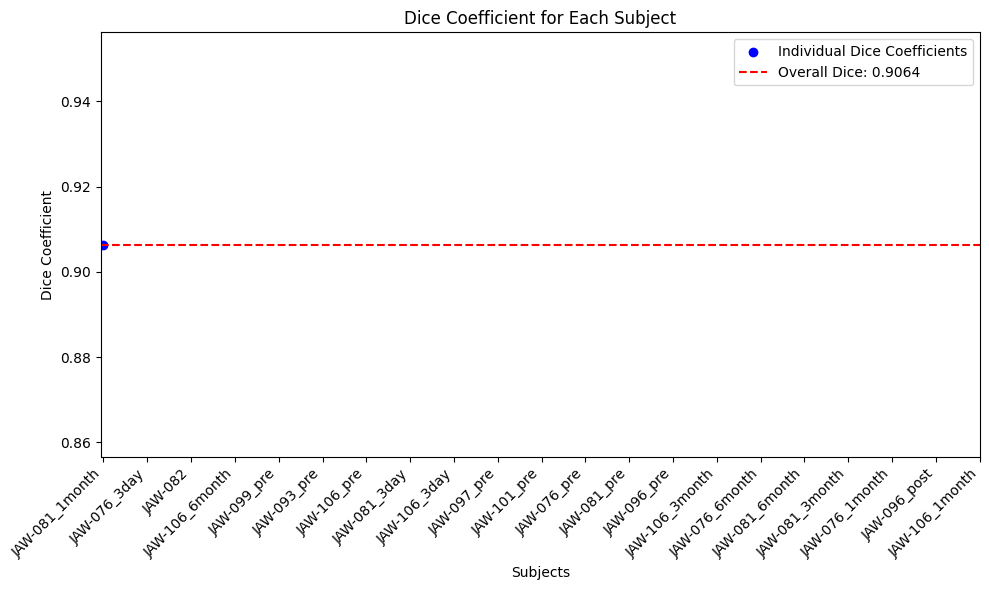

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(dice_scores)), dice_scores, color='blue', label='Individual Dice Coefficients')
plt.axhline(overall_dice, color='red', linestyle='--', label=f'Overall Dice: {overall_dice:.4f}')
plt.xlabel('Subjects')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient for Each Subject')
plt.legend()
plt.xticks(range(len(subfolders)), subfolders, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 73.2 MB/s eta 0:00:00:00:0100:01


[DEBUG] NiftiArrayIO.load(): no header extensions found!


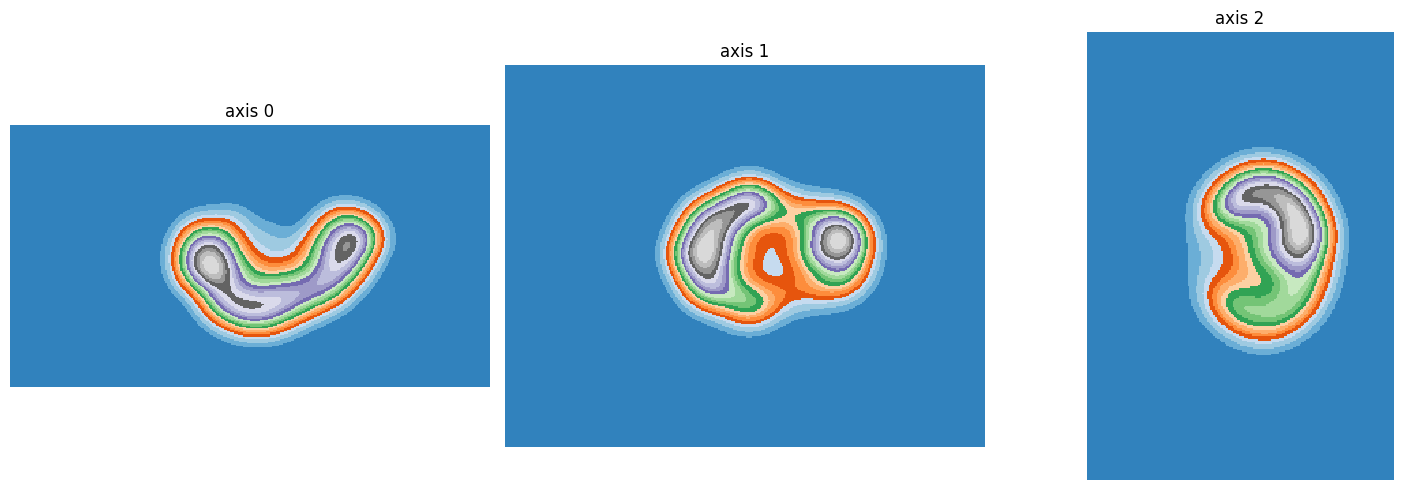

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [28]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import SimpleITK as sitk  # Import SimpleITK for image registration
from scipy.ndimage import gaussian_filter

def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=10)
    return np.round(smoothed_labels).astype(int)
    

a=sf.load_volume("/cbica/home/dadashkj/upenn_pigAnatomical/template/french_atlas.nii.gz")
a = make_smooth(a)
ne.plot.volume3D(a,cmaps=['tab20c'])

In [29]:
print(len(np.unique(a.astype(np.int32))))

116


In [26]:
len(np.unique(a))

71834